# Weak Lensing Measurements for comsoDC2

This notebook demonstrates the analysis of the weak lensing measurements of the cosmoDC2 catalog. We compare the lensing measurements of the underlying halos and the richness-selected halos from the redMaPPer cosmoDC2 catalog to investigate the selection bias.

The notebook has 4 sections:
- Loading the datasets
- Comparing with the analytical density profile models from colossus python package
- Richness-selected vs Underlying lensing measurements
- Selection Bias Diagnosis
- Show sensitivity of Halo Mass Function to change in cosmology

## Loading Python Packages

In [2]:
pwd

'/global/u1/k/kamau/Comprehensive-Exam/Computing Artifact'

In [5]:
import numpy as np
import pandas as pd

import astropy
import GCRCatalogs as gcr
from astropy.table import Table 
from colossus.cosmology import cosmology
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
plt.style.use('MatplotlibStyle.mplstyle')
# %matplotlib inline

path = r"/global/u1/k/kamau/SE-CLMM-LSSTDESC/cosmoDC2/Data/"

## Loading the datasets

In [ ]:
## Sigma and DS profile
sigma_ds_profile = pd.read_pickle(path + 's_ds_profile_full.csv').reset_index(drop=True)
print('Shape of the weak lensing measurements frame: ',sigma_ds_profile.shape,'\n')
sigma_ds_profile.head()

## Reading the perfect matched data (clusters-richness and halos)
cluster_rm = Table.read(path + 'halos/cluster_halo_2097.dat', format='ascii')
cluster_rm = cluster_rm.to_pandas()# gt_df.append(a_series, ignore_index=True)
print('Shape of the perfect-matched clusters frame: ',cluster_rm.shape,'\n')

# Reading the halos data
halos = Table.read(path + 'halos/halos-mu_0.2-1_184339.dat', format='ascii')
halos = halos.to_pandas()
print('Shape of the halos frame: ',halos.shape,'\n')

Shape of the weak lensing measurements frame:  (184338, 9) 

Shape of the perfect-matched clusters frame:  (2097, 7) 

Shape of the halos frame:  (184339, 6) 



**Preview of the read in datasets**

`sigma_ds_profile` dataframe contains properties of the halos (halo_id,location, halo_mass, redshift_true,magnification) and the computed radius and weak lensing measurements. `cluster_rm` dataframe contains halos that perfectly matched with clusters from the redMaPPer cosmoDC2 catalog. This dataframe contains the same columns as that of `halos` with additional 2 having the cluster richness and cluster redshift values assigned by redMaPPer algorithm. The halos datafrmae contains the halo quantities; halo_id,location, halo_mass, redshift_true,magnification.

In [ ]:
sigma_ds_profile[:5]

,ra,dec,halo_mass,redshift_true,halo_id,magnification,radius,sigma,DS
0,50.144265,-31.166231,1.896877e+15,0.759781,2050900064279,0.989631,"[0.12831156863525575, 0.19700895001486662, 0.3...","[969374014520125.1, 930583804564367.9, 8380468...","[27916286579801.816, -9244934984950.83, 879356..."
1,62.099645,-33.910777,1.699516e+15,0.717770,1395000096286,0.990198,"[0.128871175780952, 0.19482767400311773, 0.304...","[697469589902780.4, 651565084663119.0, 5751127...","[6204566806040.036, 22765026196042.82, 4372847..."
2,53.631944,-34.786138,1.505983e+15,0.677373,1034700093293,0.986051,"[0.12683769776060258, 0.20037066926118904, 0.3...","[246985310798901.12, 231313457745719.7, 229315...","[1386167729098.804, 11860513962167.973, 735675..."
3,61.380910,-39.995134,1.328346e+15,0.753835,935700155279,0.985931,"[0.12599037677939892, 0.19804334639377807, 0.3...","[218628300306985.72, 213467275997869.0, 194572...","[-9776251944211.424, 16542761623517.475, 16377..."
4,71.226696,-45.453151,1.134791e+15,0.448208,212800192338,0.993461,"[0.12466589823718763, 0.19832170487738998, 0.3...","[1103576700904958.0, 1005772996338092.8, 83965...","[12071562680866.045, 89067360410261.31, 163452..."


In [ ]:
cluster_rm[:5]

,dec,redshift_rm,ra,richness,halo_id,halo_mass,redshift_true
0,-46.353485,0.312542,52.619148,30.315847,161400186373,1.605630e+14,0.322793
1,-46.183597,0.451684,52.311137,69.505875,102000186338,2.329610e+14,0.450650
2,-46.176746,0.464213,52.531920,41.650291,1102300186338,1.816874e+14,0.461284
3,-46.167205,0.420232,58.975844,31.170126,193700188347,2.159097e+14,0.411005
4,-46.163924,0.876864,49.972336,42.336769,952100185266,2.797273e+14,0.853633


In [ ]:
halos[:5]

,ra,dec,halo_mass,redshift_true,halo_id,magnification
0,50.144265,-31.166231,1.896877e+15,0.759781,2050900064279,0.989631
1,62.099645,-33.910777,1.699516e+15,0.717770,1395000096286,0.990198
2,53.631944,-34.786138,1.505983e+15,0.677373,1034700093293,0.986051
3,61.380910,-39.995134,1.328346e+15,0.753835,935700155279,0.985931
4,71.226696,-45.453151,1.134791e+15,0.448208,212800192338,0.993461


**Visual view of the weak lensing signal**

We plot the first 1000 lensing measurements individually. We also plot the mean of the lensing measurements of all the extracted halos.

We filter halos of `halo_mass` between $1\mathrm{e}14$ and $2\mathrm{e}14$ and `redshift` between $0.2$ and $0.3$. This results in $301$ halos.

In [ ]:
halo_mass_bin = sigma_ds_profile[(sigma_ds_profile['halo_mass']>=1e14) & (sigma_ds_profile['halo_mass']<=2e14) &
                            (sigma_ds_profile['redshift_true']>=0.2) & (sigma_ds_profile['redshift_true']<=0.3)]
halo_mass_bin = halo_mass_bin.reset_index()
print(halo_mass_bin.shape)
halo_mass_bin.head()

(301, 10)


,index,ra,dec,halo_mass,redshift_true,halo_id,magnification,radius,sigma,DS
0,1324,67.574383,-25.555261,1.993756e+14,0.292548,445700026382,1.016005,"[0.13137197898584185, 0.19988956910412709, 0.3...","[260754122299444.75, 221353284475931.5, 176952...","[5648810193019.594, 13416566691054.094, 369981..."
1,1341,71.589170,-34.896905,1.983853e+14,0.250644,161300115392,0.997528,"[0.13018628259311374, 0.19924312780299952, 0.3...","[197218601118163.5, 167256962357950.8, 1072763...","[8184595470265.187, 39781238452354.1, 47385304..."
2,1343,70.888567,-34.230798,1.981487e+14,0.292975,234000099382,0.997262,"[0.12941917657026936, 0.19924895035466522, 0.3...","[255828166722997.5, 215625128405856.3, 1530520...","[4786305832011.809, 14305150149397.541, 523412..."
3,1346,71.015230,-39.646734,1.980370e+14,0.218573,241100158401,0.997065,"[0.13030788939498922, 0.19506490961505318, 0.2...","[221776215229657.4, 230755462201818.78, 159971...","[-6566604296566.641, 7450701578110.951, 402341..."
4,1371,68.177265,-38.900508,1.967503e+14,0.223678,107300144401,1.001290,"[0.12755468463291558, 0.20482257474644405, 0.3...","[396652174757109.4, 301386918272028.2, 1987333...","[20936917465845.85, 60419269069217.62, 1021572..."


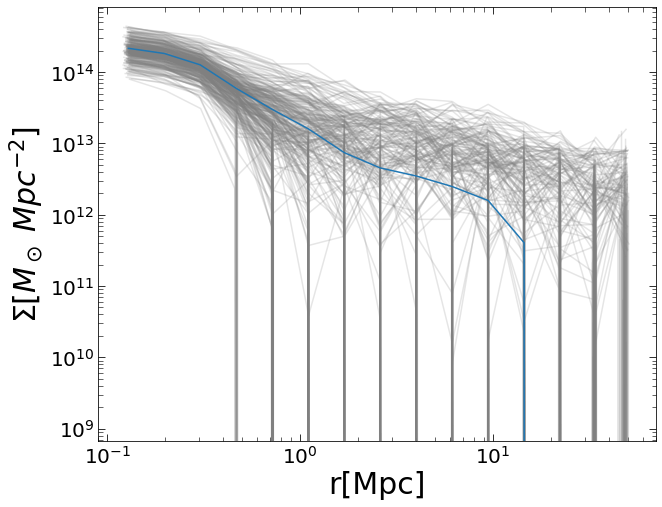

In [ ]:
for i in range(301):
    plt.loglog(halo_mass_bin['radius'][i],halo_mass_bin['sigma'][i],c='grey',alpha=0.2)
plt.loglog(halo_mass_bin['radius'].mean(),halo_mass_bin['sigma'].mean(), label = 'computed $\Delta\Sigma$')
plt.xlabel('r[Mpc]')
plt.ylabel('$\Sigma [M_\odot\; Mpc^{-2}]$')
plt.show()

The dropping of the signal is because we are plotting a log plot of profiles having negative values.

These convergence values are scaled by the geometry-dependent critical surface density $\Sigma_{crit}$ to give the surface mass density $\Sigma(R)$.

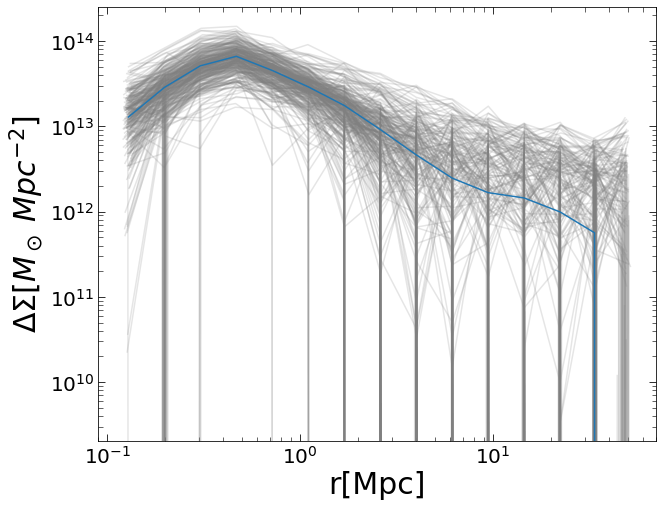

In [ ]:
for i in range(301):
    plt.loglog(halo_mass_bin['radius'][i],halo_mass_bin['DS'][i],c='grey',alpha=0.2)
plt.loglog(halo_mass_bin['radius'].mean(),halo_mass_bin['DS'].mean(), label = 'computed $\Delta\Sigma$')
plt.xlabel('r[Mpc]')
plt.ylabel('$\Delta\Sigma [M_\odot\; Mpc^{-2}]$')
plt.show()

The dropping of the signal is because we are plotting a log plot of profiles having negative values. We also observe an early drop of the signal at around the radius of $0.8\mathrm{Mpc}$ from the center of the cluster due to pixelization (resolution limits) and noise in the shear maps. 

These values (tangential shear values) are scaled by the geometry-dependent critical surface density $\Sigma_{crit}$ to give the excess surface mass density $\Delta\Sigma(R)$.

## Comparing with the analytical density profile models
To clearly compare the analytical and what we have computed, we use the filtered halos of `halo_mass` between $1\mathrm{e}14$ and $2\mathrm{e}14$ and `redshift` between $0.2$ and $0.3$. This results in $301$ halos.

**Theoretical plot using colossus package**

We start by defining the assumed cosmology under which cosmoDC2 catalog was simulated.

In [ ]:
# Theoretical plot
catalog_440 = gcr.load_catalog('cosmoDC2_v1.1.4')
gcosmology = catalog_440.cosmology
params = {'flat': True, 'H0': gcosmology.H0.value, 'Om0': gcosmology.Om0 - gcosmology.Ob0, 'Ob0': gcosmology.Ob0,
         'sigma8': gcosmology.sigma8, 'ns':gcosmology.n_s}
cosmo = cosmology.setCosmology('cosmo', params)

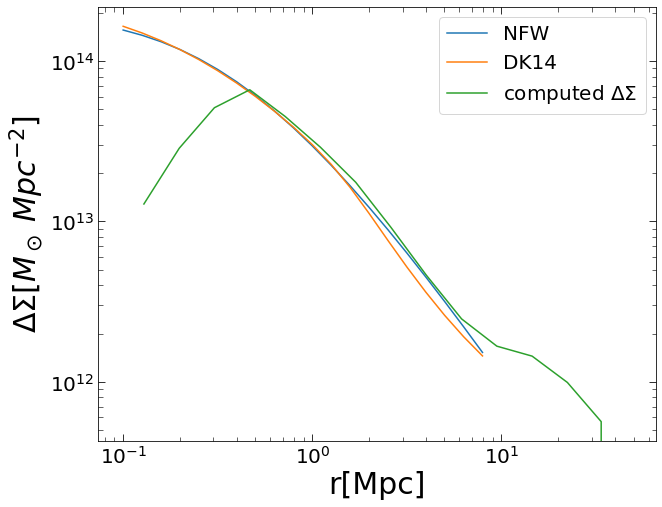

In [ ]:
from colossus.halo import profile_nfw, profile_dk14

Mvir = 1e14
cvir = 4
z = 0.2
p_nfw = profile_nfw.NFWProfile(M = Mvir, c = cvir, z = z, mdef = 'vir')
p_dk14 = profile_dk14.getDK14ProfileWithOuterTerms(M = Mvir, c = cvir, z = z, mdef = 'vir',
                                                   outer_term_names = ['pl'])

r = (10**np.arange(2,4,0.1)) 
rho_nfw_ds = p_nfw.deltaSigma(r)
rho_dk14_ds = p_dk14.deltaSigma(r)

plt.loglog(r*1e-3, rho_nfw_ds*1e6, '-', label = 'NFW')
plt.loglog(r*1e-3, rho_dk14_ds*1e6, '-', label = 'DK14')
plt.loglog(halo_mass_bin['radius'].mean(),halo_mass_bin['DS'].mean(), label = 'computed $\Delta\Sigma$')
plt.xlabel('r[Mpc]')
plt.ylabel('$\Delta\Sigma [M_\odot\; Mpc^{-2}]$')
plt.legend()
plt.show()

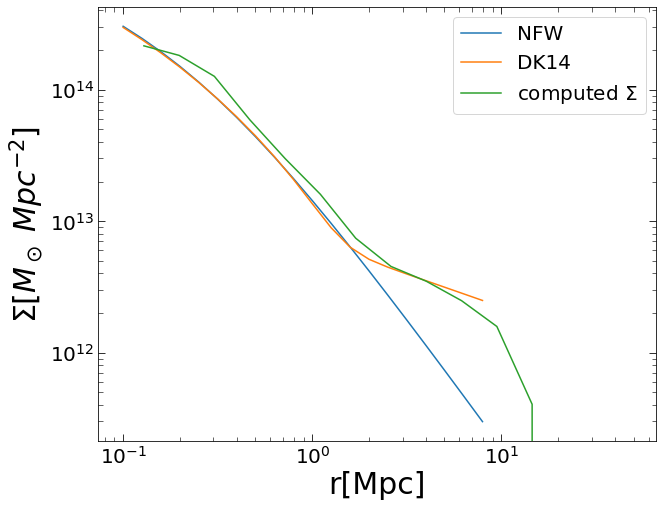

In [ ]:
rho_nfw_s = p_nfw.surfaceDensity(r)
rho_dk14_s = p_dk14.surfaceDensity(r)

plt.xlabel('r[Mpc]')
plt.ylabel('$\Sigma [M_\odot\; Mpc^{-2}]$')
plt.loglog(r*1e-3, rho_nfw_s*1e6, '-', label = 'NFW')
plt.loglog(r*1e-3, rho_dk14_s*1e6, '-', label = 'DK14')
plt.loglog(halo_mass_bin['radius'].mean(),halo_mass_bin['sigma'].mean(), label = 'computed $\Sigma$')
plt.legend()
plt.show()

The computed weak lensing signal is consistent with the analytical models.

## Richness-selected vs Underlying lensing measurement
In this section we invetigate the weak lensing selection bias. To get the richness-selected dataframe we `inner-merge` `cluster_rm` and `sigma_ds_profile` dataframes. The resulting dataframe has the same shape as the `cluster_rm` dataframe. this implies that all the perfect-matched halos have their corresponding weak lensing measurements.

In [ ]:
richness_selected = cluster_rm[['dec', 'redshift_rm', 'ra', 'richness', \
 'halo_id']].merge(sigma_ds_profile[['halo_mass', 'redshift_true', 'halo_id',
       'radius', 'sigma', 'DS']], how='inner',on='halo_id')
print('Shape of the richness-selected cluster frame: ',richness_selected.shape)
richness_selected.sample(5)

Shape of the richness-selected cluster frame:  (2097, 10)


,dec,redshift_rm,ra,richness,halo_id,halo_mass,redshift_true,radius,sigma,DS
556,-39.793632,0.517180,51.749433,23.557894,93000138323,1.278588e+14,0.513790,"[0.1298070109811241, 0.20117017869126613, 0.30...","[114537915063308.3, 110448626343976.31, 104052...","[714224384276.7972, 3029232299399.8857, 102803..."
1669,-29.295925,0.897833,68.221889,22.139181,33400058259,1.442031e+14,0.893325,"[0.1241030598251016, 0.19869840982751052, 0.30...","[81293033392266.16, 75371182968968.17, 6199511...","[-4652651950768.908, 13484531535107.451, 93131..."
1844,-27.793240,0.805375,70.948645,26.593634,1402000037272,1.096430e+14,0.801848,"[0.1263940040064993, 0.19644542998995249, 0.30...","[56621412415441.17, 43134520199926.08, 3141580...","[2946085161250.876, 6470007142893.038, 8303535..."
97,-44.592910,0.357741,68.467234,24.518957,53700181365,2.759038e+14,0.352965,"[0.1287642159206975, 0.19432100877821845, 0.30...","[314075300577741.0, 273753657978431.53, 211556...","[18330779118010.44, 19566329426866.188, 585372..."
480,-40.645236,0.493470,49.348633,43.465637,518400163331,1.427553e+14,0.497166,"[0.1273278041010993, 0.1973746531442954, 0.308...","[261784937359005.22, 236517424486653.34, 19906...","[6142086900654.227, 19693835532320.73, 3545332..."


Distribution of the cluster true redshift

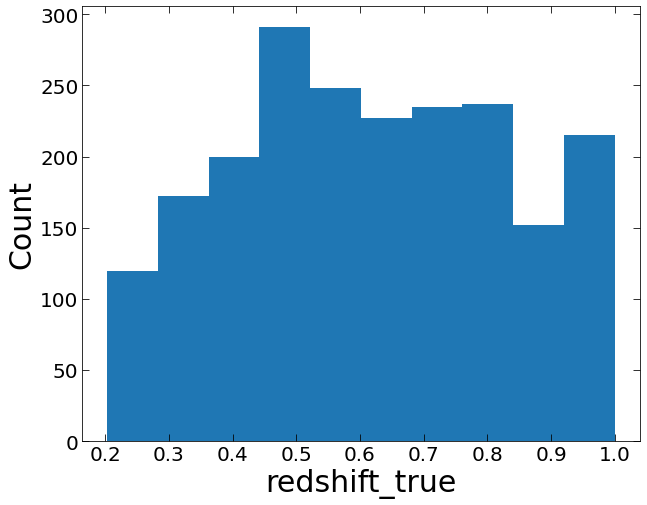

In [ ]:
plt.hist(richness_selected['redshift_true'])
plt.xlabel("redshift_true")
plt.ylabel("Count")
plt.show()

Let us visualize the mean lensing signal calculated using the `richness_selected` and `sigma_ds_profile` dataframes. From the plot we can observe that the $\Delta\Sigma$ drops at approximately Radius= $0.8\mathrm{Mpc}$. However, the $\Sigma$ profile, is not affected by the low resolution at low radius. For this reason we might use $\Sigma$ to explaing the lensing signal at low radius and $\Delta\Sigma$ at approximately Radius $> 1\mathrm{Mpc}$

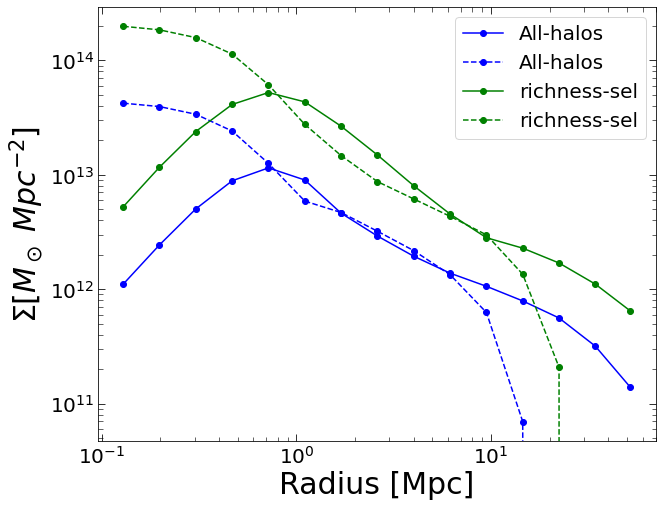

In [ ]:
# Plot of richness-selected vs all profiles.....ds and sigma
plt.loglog(sigma_ds_profile['radius'].mean(), sigma_ds_profile['DS'].mean(),marker='o',color='blue', label='All-halos')
plt.loglog(sigma_ds_profile['radius'].mean(), sigma_ds_profile['sigma'].mean(),marker='o',color='blue',linestyle='dashed', label='All-halos')
plt.loglog(richness_selected['radius'].mean(),richness_selected['DS'].mean(), marker='o', color='green',label='richness-sel')
plt.loglog(richness_selected['radius'].mean(),richness_selected['sigma'].mean(), marker='o',color='green', linestyle='dashed',label='richness-sel')
plt.xlabel("Radius [Mpc]")
plt.ylabel('$\Sigma [M_\odot\; Mpc^{-2}]$')
lgd = plt.legend()

## Selection Bias Diagnosis

We start the selection bias diagnosis by filtering the halos to be within the redshift of $0.2$ and $0.3$ from the `richness_selected` and `sigma_ds_profile` dataframes. We implement the same technique used in <a href='https://ui.adsabs.harvard.edu/abs/2022MNRAS.515.4471W/abstract'>Wu et al. (2022)</a> to investigate the lensing selection bias. The technique uses the weighting method where we use all halos from the `sigma_ds_profile` weighted by the PDF of the `richness_selected` sample. The halos are put in narrow mass bins and compute the mean lensing signal from each bin. We then compute the weight associated with each narrow mass bin using the PDF of the richness_selected sample. Finally we perform a weighted average of the weak lensing signal from all the mass bins.

In [ ]:
richeness_2_3 = richness_selected[(richness_selected['redshift_true']>0.2) & (richness_selected['redshift_true']<0.3)]
halos_2_3 = sigma_ds_profile[(sigma_ds_profile['redshift_true']>0.2) & (sigma_ds_profile['redshift_true']<0.3)]

In [ ]:
## Weighted Profile
def stacked_profile_weighted_by_mass_redshift(lnM_select, z_select, prof_select, lnM_all, z_all, profile_A, dm=0.1, dz=0.05):
    #### set up the bins for mass and redshift  (sigma_select/profile_select, sigma_all/profile_all)
    min_m = min(lnM_select)#-dm
    max_m = max(lnM_select)#+dm
    min_z = min(z_select)#-dz
    max_z = max(z_select)#+dz

    m_bins = np.arange(min_m, max_m+dm, dm)
    z_bins = np.arange(min_z, max_z+dz, dz)
    nM = len(m_bins)-1
    nz = len(z_bins)-1

    profile_select = np.array([i.tolist() for i in prof_select])
    profile_all = np.array([i.tolist() for i in profile_A])

    nr = np.shape(profile_select)[1]#rbp.nbins_phys_mpc...1
    profile_weighted = np.zeros(nr)
    weight_norm = 0


    pdf1_list = np.zeros([nz, nM]) # see how many bins are too narrow
    pdf2_list = np.zeros([nz, nM]) # see how many bins are too narrow

    for iz in range(nz):
        z_lo = z_bins[iz]
        z_hi = z_bins[iz+1]
        for iM in range(nM):
            m_lo = m_bins[iM]
            m_hi = m_bins[iM+1]
            
            select_bin = (lnM_select >= m_lo)&(lnM_select < m_hi)&(z_select>=z_lo)&(z_select<z_hi)
            weight = len(lnM_select[select_bin]) * 1.
            weight_norm += weight
            select_all = (lnM_all >= m_lo)&(lnM_all < m_hi)&(z_all>=z_lo)&(z_all<z_hi)

            pdf1_list[iz, iM] = weight
            pdf2_list[iz, iM] = len(lnM_all[select_all])

            if weight > 0 and len(lnM_all[select_all]) > 0:
                profile_weighted += (np.mean(profile_all[select_all, :], axis=0)*weight) #0
    profile_weighted /= weight_norm

    pdf1_list = np.concatenate(pdf1_list)
    pdf2_list = np.concatenate(pdf2_list)
    diff_list = pdf2_list - pdf1_list
    print('pdf1==pdf2', len(diff_list[diff_list == 0]), 'out of', len(diff_list))

    return profile_weighted

In [ ]:
lnM_sel = np.log10(richeness_2_3['halo_mass'])
z_sel = richeness_2_3['redshift_true']
profile_sel = richeness_2_3['sigma']
profile_sel_ds = richeness_2_3['DS']

lnM_All = np.log10(halos_2_3['halo_mass'])
z_All = halos_2_3['redshift_true']
profile_All = halos_2_3['sigma']
profile_All_ds = halos_2_3['DS']

expected_sigma = stacked_profile_weighted_by_mass_redshift(lnM_sel, z_sel, profile_sel, lnM_All, z_All, profile_All, dm=0.1, dz=0.05)
expected_ds = stacked_profile_weighted_by_mass_redshift(lnM_sel, z_sel, profile_sel_ds, lnM_All, z_All, profile_All_ds, dm=0.1, dz=0.05)

pdf1==pdf2 2 out of 30
pdf1==pdf2 2 out of 30


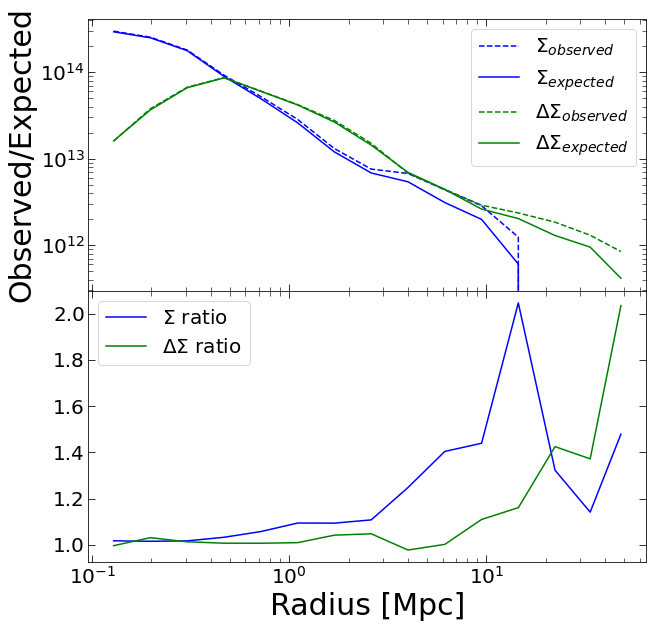

In [28]:
### Sigma plot of observed vs expected
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(211)
ax1.loglog(richeness_2_3['radius'].mean(),richeness_2_3['sigma'].mean(),color='blue',linestyle='dashed', label='$\Sigma_{observed}$')
ax1.loglog(richeness_2_3['radius'].mean(),expected_sigma,color='blue',label='$\Sigma_{expected}$')

ax1.loglog(richeness_2_3['radius'].mean(),richeness_2_3['DS'].mean(),color='green',linestyle='dashed', label='$\Delta\Sigma_{observed}$')
ax1.loglog(richeness_2_3['radius'].mean(),expected_ds,color='green',label='$\Delta\Sigma_{expected}$')
ax1.set_ylabel('Observed/Expected')

ax2 = plt.subplot(212, sharex = ax1)
ax2.semilogx(richeness_2_3['radius'].mean(),richeness_2_3['sigma'].mean()/expected_sigma,color='blue',label='$\Sigma$ ratio')
ax2.semilogx(richeness_2_3['radius'].mean(),richeness_2_3['DS'].mean()/expected_ds,color='green',label='$\Delta\Sigma$ ratio')
ax2.set_xlabel("Radius [Mpc]")
lgd = ax1.legend();ax1.legend()
lgd = ax2.legend();ax2.legend()
plt.subplots_adjust(hspace=.0)
plt.setp(ax1.get_xticklabels(), visible=False)
# remove last tick label for the second subplot
yticks = ax1.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
plt.savefig('/global/u1/k/kamau/SE-CLMM-LSSTDESC/cosmoDC2/Images/sigma_DeltaSigma.jpg', bbox_inches='tight')
plt.show()

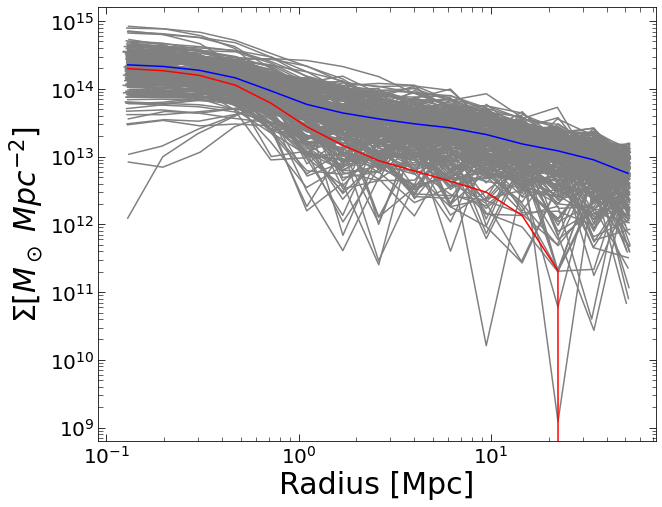

231
1866 



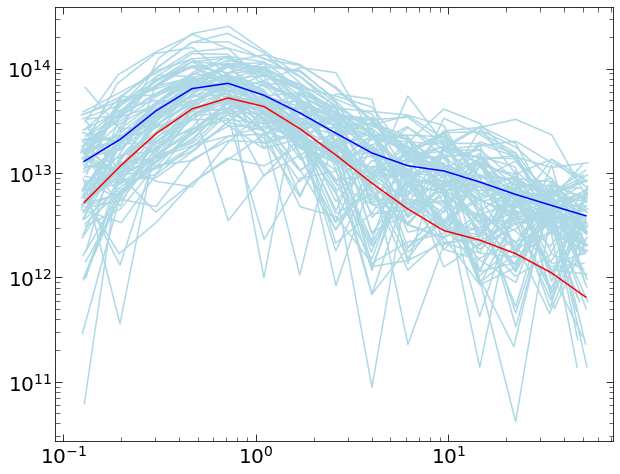

In [ ]:
## Plotting the positive values
empty_p = []
empty_p_values = []
empty_n = []

mean_Sigma = np.zeros(15)
nhalo=0
for i in range(0,richness_selected.shape[0]):
    if np.any(richness_selected['sigma'][i]<0):
        empty_n.append(i)
    else:
        empty_p.append(i)
        empty_p_values.append(richness_selected['sigma'][i])
        plt.loglog(richness_selected['radius'][i],richness_selected['sigma'][i], label='$\Sigma_{observed}$',color='grey')
        mean_Sigma += richness_selected['sigma'][i]
        nhalo += 1
plt.plot(richness_selected['radius'].mean(),mean_Sigma/nhalo, color='blue')
plt.plot(richness_selected['radius'].mean(),richness_selected['sigma'].mean(), color='red')
plt.xlabel("Radius [Mpc]")
plt.ylabel('$\Sigma [M_\odot\; Mpc^{-2}]$')
# plt.savefig('Images/selected_Sigma_300.jpg')
plt.show()
print(len(empty_p))
print(len(empty_n), '\n')

mean_ds = np.zeros(15)
nhalo_ds=0
for i in range(0,richness_selected.shape[0]):
    if np.any(richness_selected['DS'][i]<0):
        pass
    else:
        plt.loglog(richness_selected['radius'][i],richness_selected['DS'][i], label='$\Sigma_{observed}$',color='lightblue')
        mean_ds += richness_selected['DS'][i]
        nhalo_ds += 1
plt.plot(richness_selected['radius'].mean(),mean_ds/nhalo_ds, color='blue')
plt.loglog(richness_selected['radius'].mean(),richness_selected['DS'].mean(), color='red')
plt.show()

The plot shows the mean of both the surface mass density and the excess surface mass density of cosmoDC2 clusters. At small scale the expected and observed surface mass density (blue) is consistent while at large scale we see a boost of the observed signal. The expected is computed using the underlying halos while observed is computed using the richness-selected clusters.


For the excess surface mass density (green), the expected and observed signal is also consistent at small scale while at large scale we see a boost of the observed signal. The expected is computed using the underlying halos while observed is computed using the richness-selected clusters. 

The lower panel shows the ratio of the respective signals. It clearly shows the discrepancies between the signals from the radius of $1\mathrm{Mpc}$. we suspect the boosting of the signal is resulting from the selection bias caused by the redMaPPer algorithm.

## How sensitive is HMF to change in cosmological parameters?
Halo mass function shows the number density of halos per mass range for a given cosmology. It provides the connection between cosmological parameters and cluster abundance.

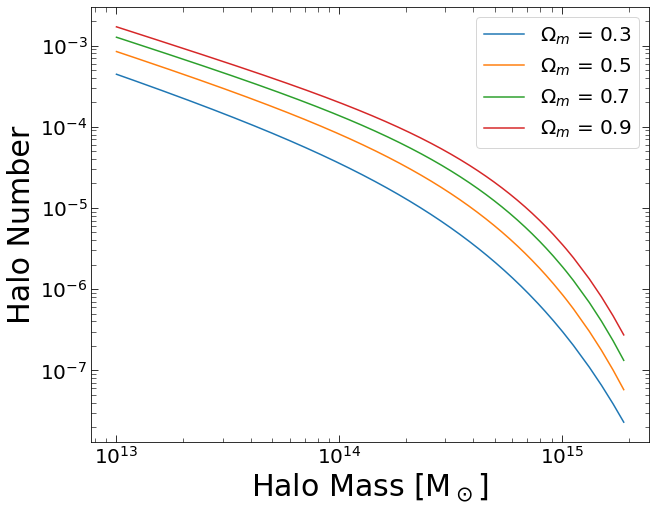

In [ ]:
## Varying matter density
from colossus.lss import mass_function
for md in np.arange(0.3,1,0.2):
    params = {'flat': True, 'H0': gcosmology.H0.value, 'Om0':md, 'Ob0': 0.0448,'sigma8': 0.8, 'ns':0.963}
    cosmology.setCosmology('cosmo', params)
    
    M = halos['halo_mass']

    z = 0.2
    mfunc = mass_function.massFunction(M, z, q_out = 'dndlnM')
    plt.loglog(M, mfunc, '-', label = '$\Omega_m$ = %.1f' % (md))

plt.xlabel('Halo Mass [M$_\odot]$')
plt.ylabel('dndlnM')
lgd = plt.legend()
# plt.savefig('/global/u1/k/kamau/SE-CLMM-LSSTDESC/cosmoDC2/Images/Halo_Mass_w_changing_md.jpg', bbox_inches='tight')
plt.show()

The plot shows how HMF changes with an increase in matter density value. Higher matter density ($\Omega_m$) leads to the increase in number density of halo masses at low and high mass.

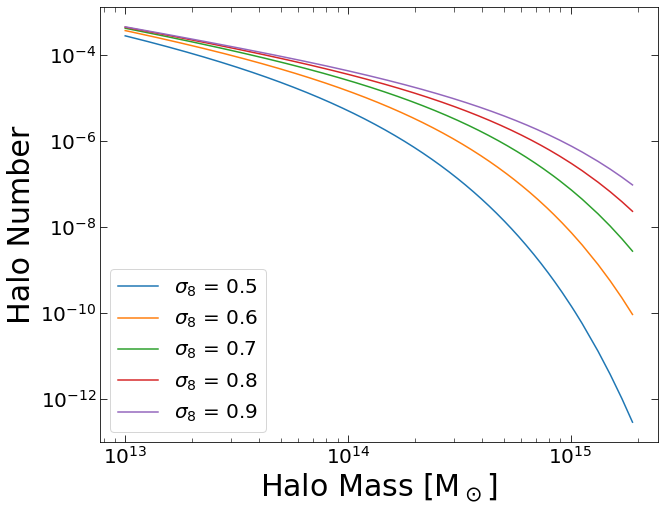

In [ ]:
## Varying density fluctuation
for s8 in np.arange(0.5,1,0.1):
    params = {'flat': True, 'H0': gcosmology.H0.value, 'Om0':0.3, 'Ob0': 0.0448,'sigma8': s8, 'ns':0.963}
    cosmology.setCosmology('cosmo', params)

    M = halos['halo_mass']
    z = 0.2
    mfunc = mass_function.massFunction(M, z, q_out = 'dndlnM')
    plt.loglog(M, mfunc, '-', label = '$\sigma_8$ = %.1f' % (s8))

plt.xlabel('Halo Mass [M$_\odot]$')
plt.ylabel('dndlnM')
lgd = plt.legend()
# plt.savefig('/global/u1/k/kamau/SE-CLMM-LSSTDESC/cosmoDC2/Images/Halo_Mass_w_changing_s8.jpg', bbox_inches='tight')
plt.show()

The plot shows how HMF varies with an increase in density fluctuation parameter. Higher density fluctuation parameter ($\sigma_8$) leads to an increase in number density of massive halos.